In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
echo = pd.read_csv("../merged50Pediatric_ECHO.csv")
manifest = pd.read_csv("../manifest50Pediatric.tsv", sep = '\t')

In [3]:
analysis_type = 'cancerTypeDetailed'

### Clean Up Dataframe

In [4]:
echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

In [5]:
manifest = manifest[['sampleId', 'cancerType', 'cancerTypeDetailed', 'osStatus', 'osMonths']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')

Get a dictionary specific to each patient

In [6]:
ecDNA_per_patient = {}
for idx, row in echo.iterrows() :
    if row['patientId'] not in ecDNA_per_patient :
        ecDNA_per_patient[row['patientId']] = ''
    if row['ecDNA_status'] == 'ecDNA' :
        if ecDNA_per_patient[row['patientId']] == '' :
            ecDNA_per_patient[row['patientId']] = row['gene']
        else :
            ecDNA_per_patient[row['patientId']] += '_' + row['gene']

Create dataframe per patient

In [7]:
patientsList = echo['patientId'].unique()

ecDNA_patient = pd.DataFrame(patientsList, columns = ['patientId'])
ecDNA_patient['ecDNAStatus'] = None
ecDNA_patient['ecDNAList'] = ''

for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient.loc[idx, 'ecDNAList'] = ecDNA_per_patient[row['patientId']]
    if ecDNA_per_patient[row['patientId']] == '' :
        ecDNA_patient.loc[idx, 'ecDNAStatus'] = False
    else :
        ecDNA_patient.loc[idx, 'ecDNAStatus'] = True


Add copy number (taking the largest copy number)

In [8]:
max_copy_number = {}
for idx, row in echo.iterrows() :
    if row['patientId'] in max_copy_number :
        max_copy_number[row['patientId']] = max(max_copy_number[row['patientId']], row['cn'])
    else :
        max_copy_number[row['patientId']] = row['cn']

ecDNA_patient['max_cn'] = np.nan
for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient.loc[idx, 'max_cn'] = max_copy_number[row['patientId']]


### Basic Plots

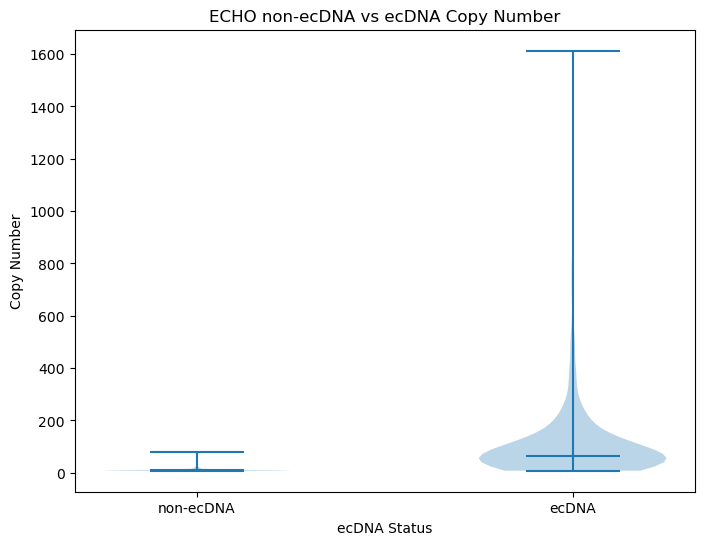

In [9]:
# Plotting violin plot
plt.figure(figsize=(8, 6))
plt.violinplot(dataset=[echo[echo['ecDNA_status'] == 'non-ecDNA']['cn'], 
                        echo[echo['ecDNA_status'] == 'ecDNA']['cn']],
               showmeans=False, showmedians=True)
plt.title('ECHO non-ecDNA vs ecDNA Copy Number')
plt.xticks([1, 2], ['non-ecDNA', 'ecDNA']) 
plt.ylabel('Copy Number')
plt.xlabel("ecDNA Status")
plt.show()

Text(0.5, 1.0, 'ECHO Probability vs Copy Number')

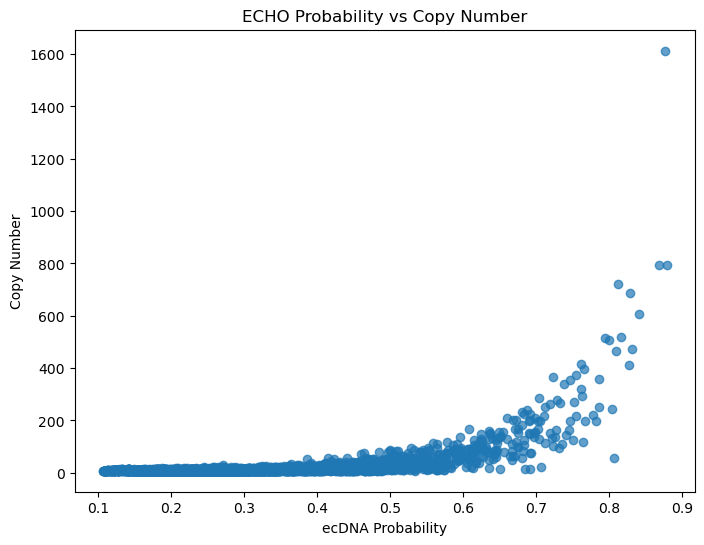

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(echo['ecDNA_prob'], echo['cn'], alpha=0.7)
plt.ylabel("Copy Number")
plt.xlabel("ecDNA Probability")
plt.title("ECHO Probability vs Copy Number")



### cBioPortal Plots

In [11]:

ecDNA_patient['vitalStatus'] = 'NA'
ecDNA_patient['cancerType'] = 'NA'
ecDNA_patient['cancerTypeDetailed'] = 'NA'
ecDNA_patient['osMonths'] = np.nan

ecDNA_patient_indexes = {}
for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient_indexes[row['patientId']] = idx

for idx, row in echo.iterrows() :
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'vitalStatus'] = row['osStatus']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'cancerType'] = row['cancerType']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'cancerTypeDetailed'] = row['cancerTypeDetailed']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'osMonths'] = row['osMonths']


### Landscape Graphs

In [12]:
ecDNA_patient_binary = ecDNA_patient[['vitalStatus', 'ecDNAStatus', analysis_type]].astype(str)
ecDNA_patient_binary_filtered = ecDNA_patient_binary[ecDNA_patient_binary['vitalStatus'] != "nan"]
crosstab = pd.crosstab(ecDNA_patient_binary_filtered['vitalStatus'], ecDNA_patient_binary_filtered['ecDNAStatus'])
crosstab

ecDNAStatus,False,True
vitalStatus,,
DECEASED,437,68
LIVING,1188,116


In [13]:
ecDNA_patient_binary_filtered['ecDNAStatus'] = ecDNA_patient_binary_filtered['ecDNAStatus'].replace({'True': 'ecDNA', 'False': 'non-ecDNA'})
ecDNA_patient_binary_filtered['Status'] = ecDNA_patient_binary_filtered['ecDNAStatus'] + " & " + ecDNA_patient_binary_filtered['vitalStatus']

/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_18725/2451063406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecDNA_patient_binary_filtered['ecDNAStatus'] = ecDNA_patient_binary_filtered['ecDNAStatus'].replace({'True': 'ecDNA', 'False': 'non-ecDNA'})
/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_18725/2451063406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecDNA_patient_binary_filtered['Status'] = ecDNA_patient_binary_filtered['ecDNAStatus'] + " & " + ecDNA_patient_bina

In [14]:
crosstab_cancerType = pd.crosstab(ecDNA_patient_binary_filtered[analysis_type], ecDNA_patient_binary_filtered['Status'])
crosstab_cancerType['tempSum'] = crosstab_cancerType[['ecDNA & LIVING', 'ecDNA & DECEASED']].sum(axis=1)
crosstab_cancerType = crosstab_cancerType.sort_values(by = 'tempSum', ascending = False)
crosstab_cancerType.drop(columns=['tempSum'], inplace = True)


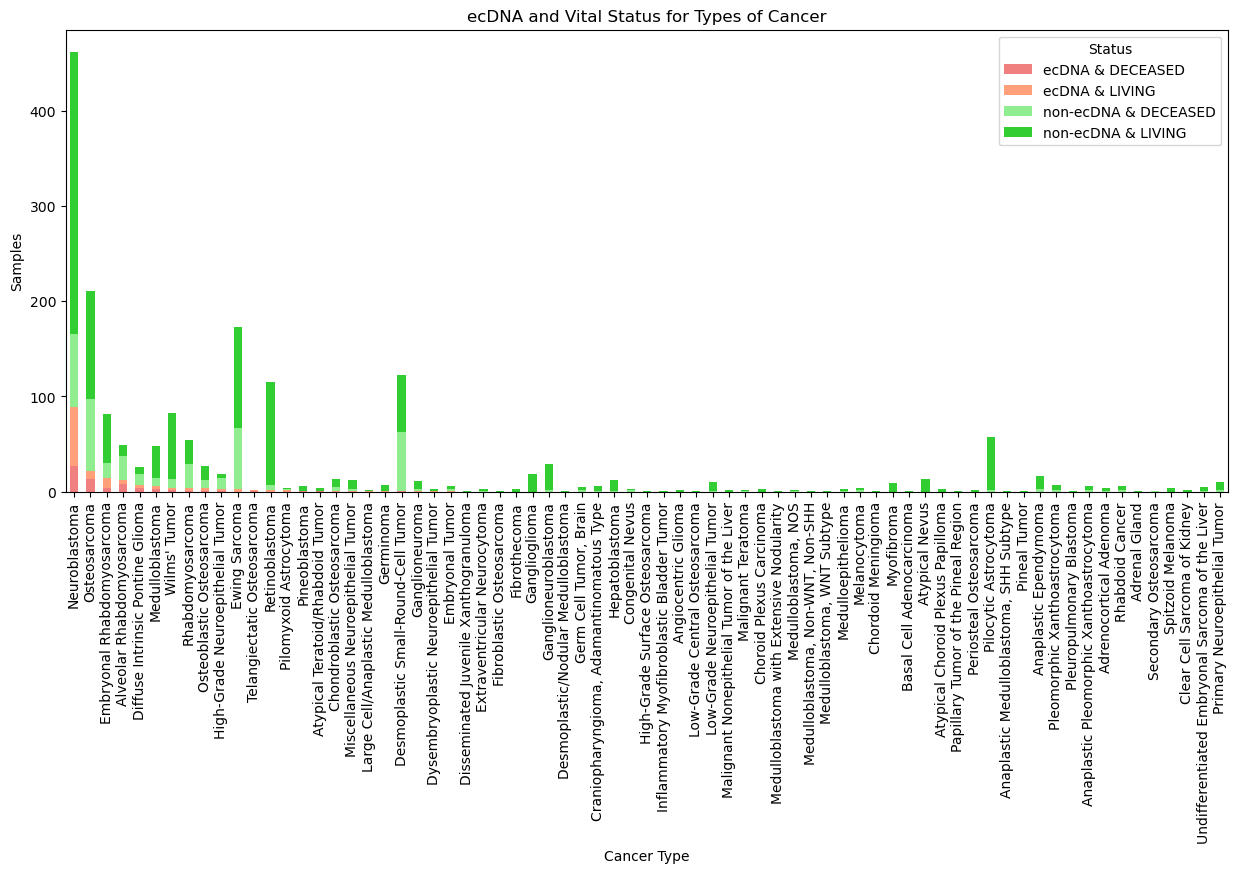

In [15]:
crosstab_cancerType.plot(kind = 'bar', stacked = True, color = ['lightcoral', 'lightsalmon', 'lightgreen', 'limegreen'], figsize = (15, 6))
plt.ylabel("Samples")
plt.xlabel("Cancer Type")
plt.title("ecDNA and Vital Status for Types of Cancer")
plt.show()

In [16]:
normalized_crosstab_cancerType = crosstab_cancerType.div(crosstab_cancerType.sum(axis = 1), axis = 0)
normalized_crosstab_cancerType['tempSum'] = normalized_crosstab_cancerType[['ecDNA & LIVING', 'ecDNA & DECEASED']].sum(axis=1)
normalized_crosstab_cancerType = normalized_crosstab_cancerType.sort_values(by = 'tempSum', ascending = False)
normalized_crosstab_cancerType.drop(columns=['tempSum'], inplace = True) 

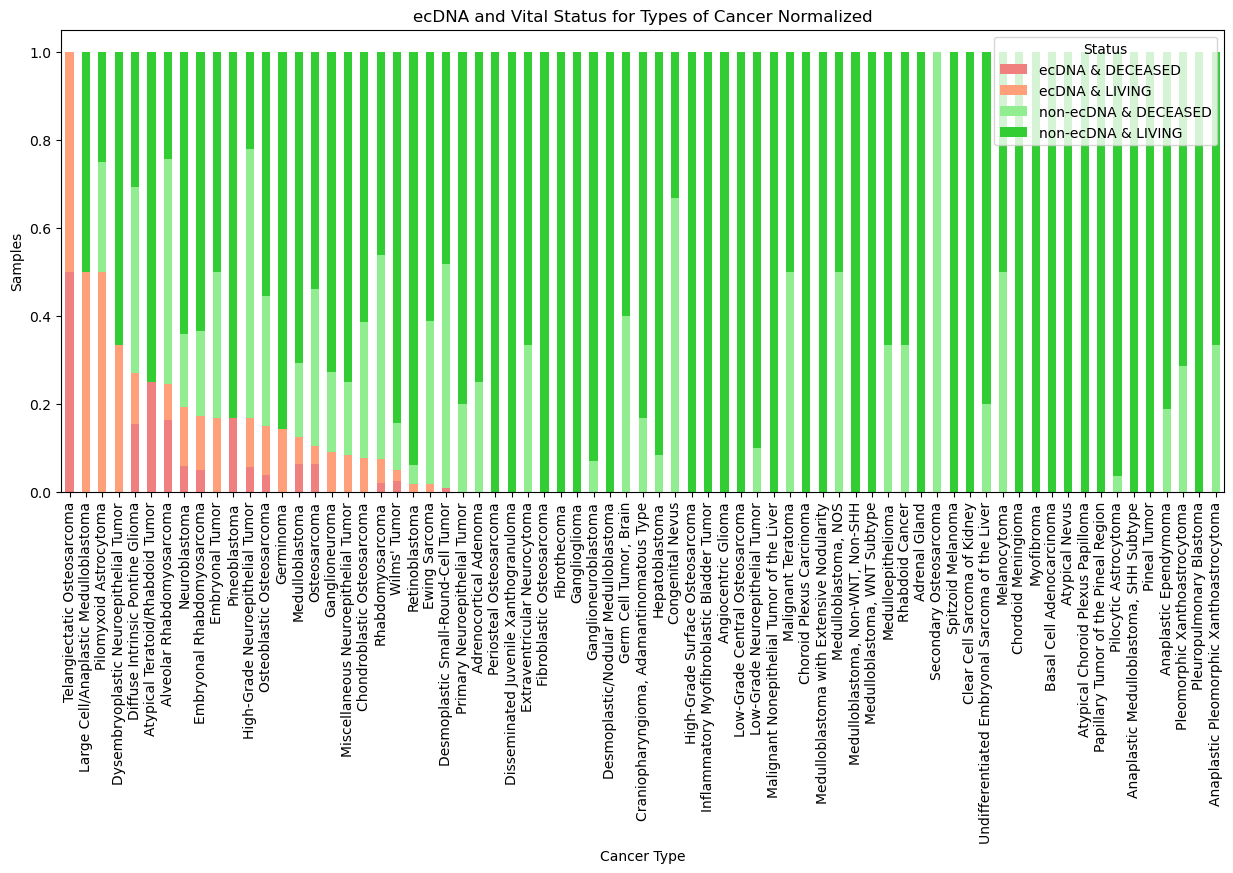

In [17]:
normalized_crosstab_cancerType.plot(kind = 'bar', stacked = True, color = ['lightcoral', 'lightsalmon', 'lightgreen', 'limegreen'], figsize=(15,6))
plt.ylabel("Samples")
plt.xlabel("Cancer Type")
plt.title("ecDNA and Vital Status for Types of Cancer Normalized")
plt.show()

### Survival (OS Months)

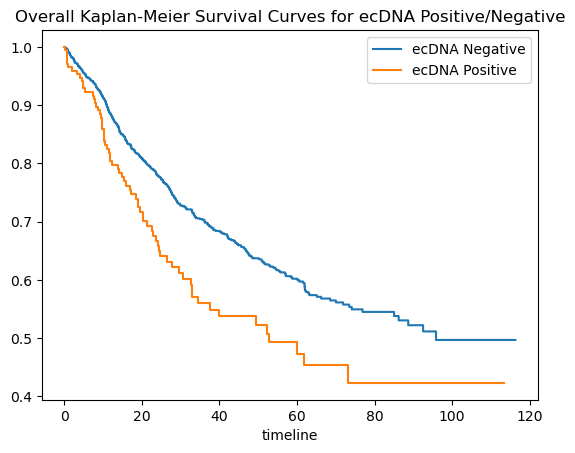

In [18]:
from lifelines import KaplanMeierFitter

ecDNA_patient_nona = ecDNA_patient.dropna(subset = ['ecDNAStatus', 'vitalStatus', 'osMonths'])

kmf = KaplanMeierFitter()
for status in ecDNA_patient_nona['ecDNAStatus'].unique():
    subset = ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == status]
    kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))
    if status == True :
        status = "ecDNA Positive"
    else :
        status = "ecDNA Negative"
    kmf.plot(show_censors=False, ci_show=False, label=f'{status}')

# # Add labels and legend
plt.title('Overall Kaplan-Meier Survival Curves for ecDNA Positive/Negative')

plt.legend()

Specific for one cancer type

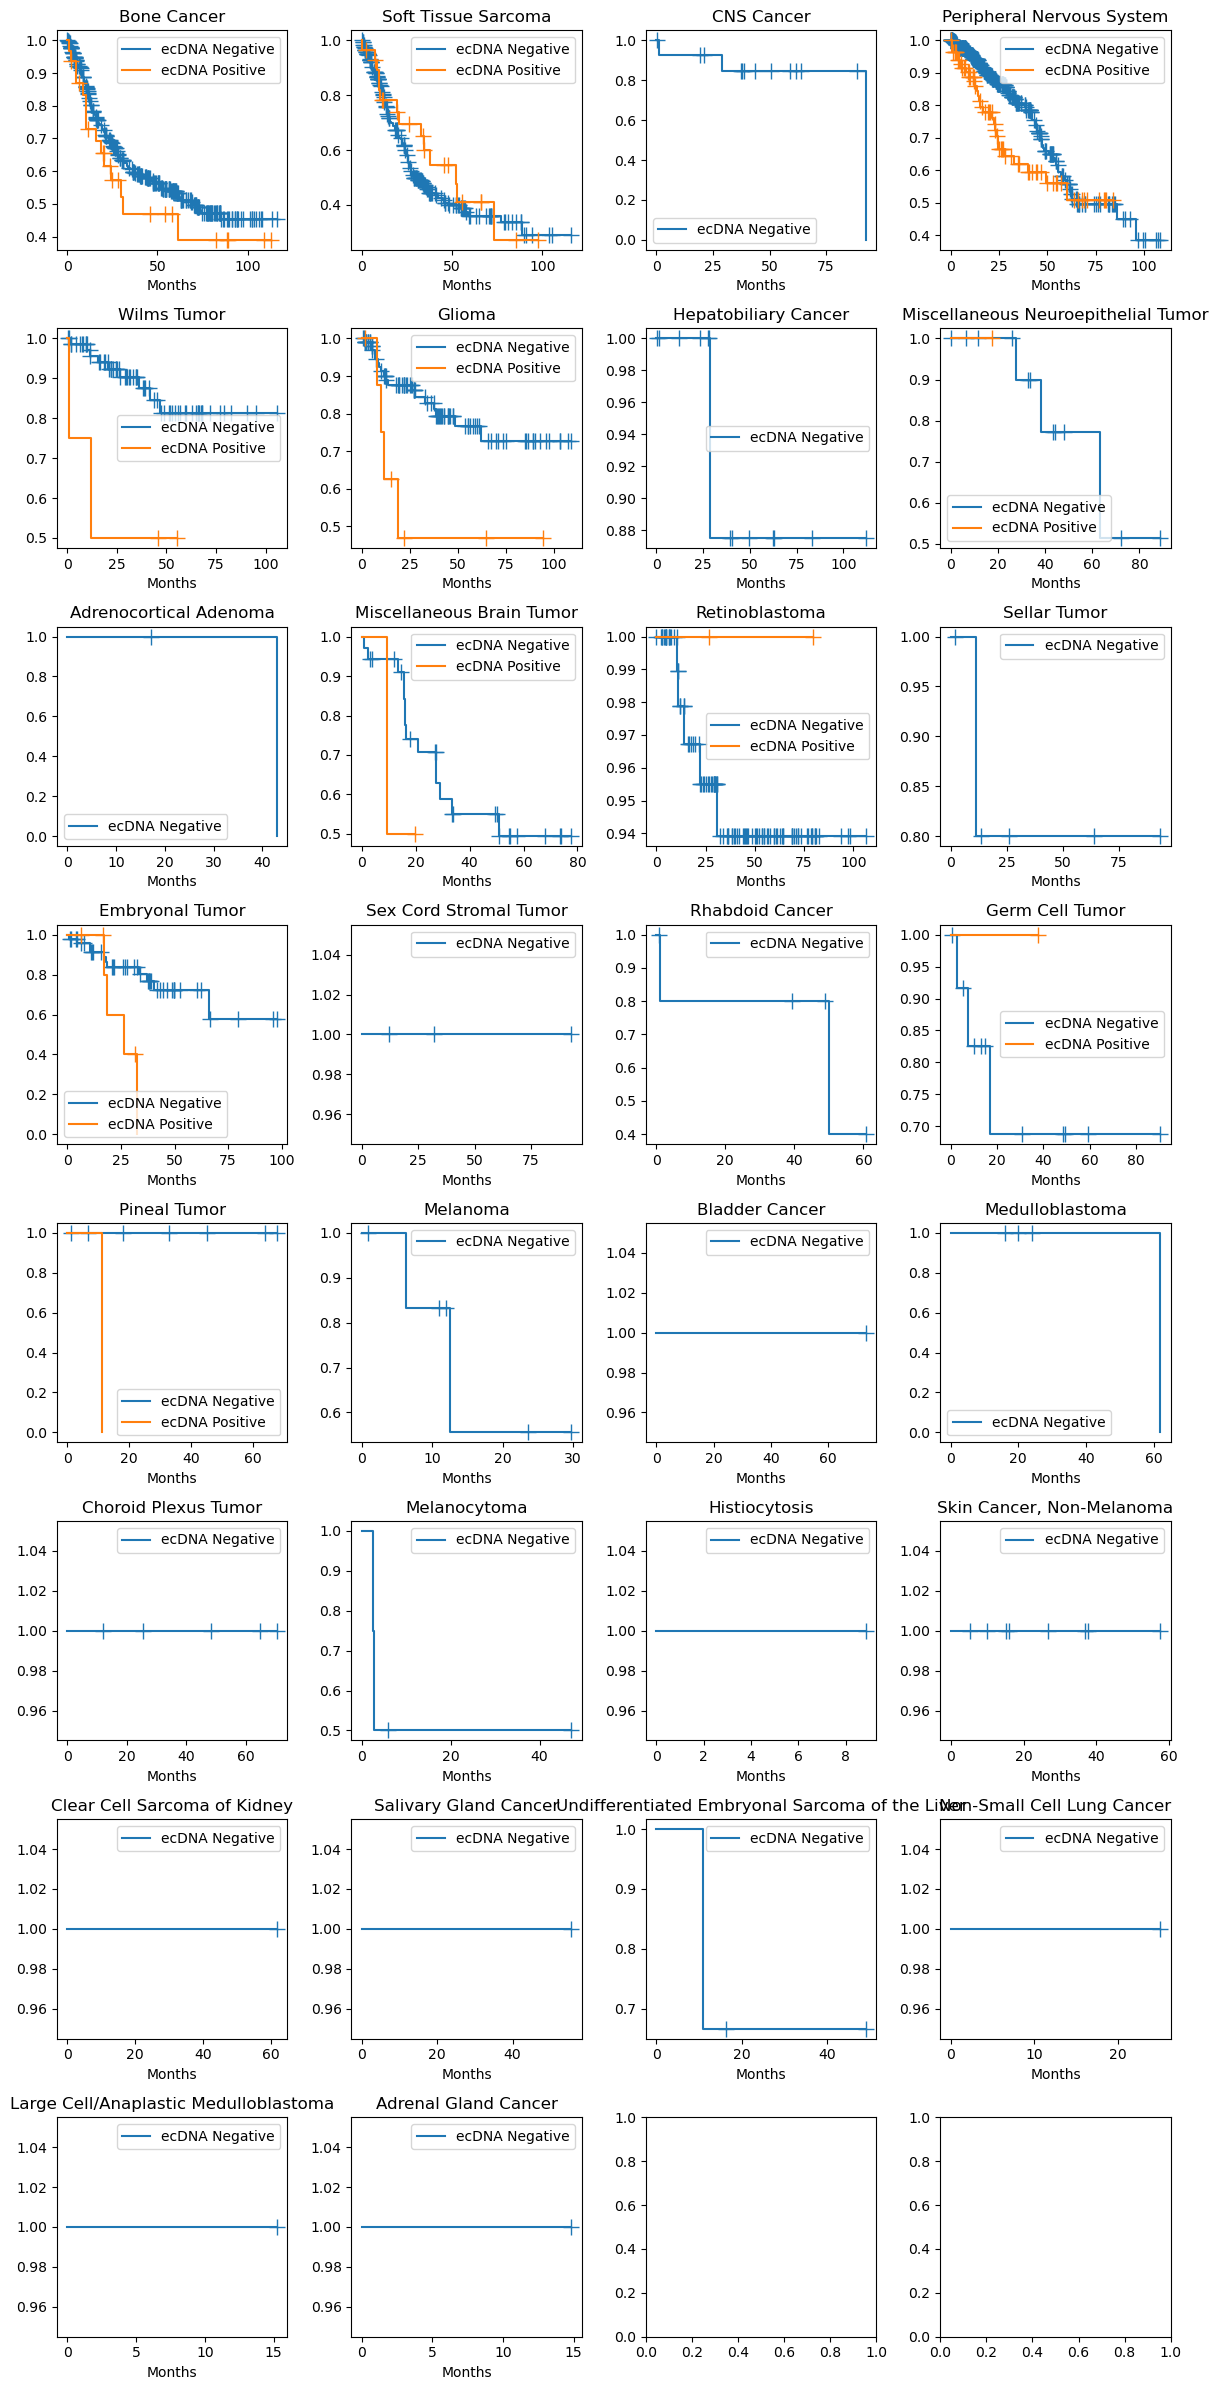

In [22]:

from lifelines import KaplanMeierFitter

ecDNA_patient_nona = ecDNA_patient.dropna(subset = ['ecDNAStatus', 'vitalStatus', 'osMonths', 'cancerType'])
cancer_types = ecDNA_patient_nona['cancerType'].unique()

fig, axs = plt.subplots((len(cancer_types)+3)//4, 4, figsize = (12, 0.8 * len(cancer_types)))
axs = axs.flatten()
for i in range(len(cancer_types)) :
    ecDNA_patient_specific = ecDNA_patient_nona[ecDNA_patient_nona['cancerType'] == cancer_types[i]]

    for status in sorted(ecDNA_patient_specific['ecDNAStatus'].unique()):

        kmf = KaplanMeierFitter()
        subset = ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == status]
        kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))
        if status == True :
            status = "ecDNA Positive"
        else :
            status = "ecDNA Negative"
        kmf.plot(show_censors=True, ci_show=False, label=f'{status}', ax = axs[i])
        axs[i].set_title(cancer_types[i])
        axs[i].set_xlabel("Months")
plt.tight_layout()
plt.show()

### Copy Number as a Covariate

Cox model

In [ ]:
ecDNA_patient_cox = ecDNA_patient.dropna(subset = ['osMonths', 'max_cn', 'ecDNAStatus', 'cancerType'])
ecDNA_patient_cox['eventOccurred'] = (ecDNA_patient_cox['vitalStatus'] == 'DECEASED').astype(int)

from lifelines import CoxPHFitter

cox = CoxPHFitter()
covariates = ['osMonths', 'max_cn', 'eventOccurred', 'ecDNAStatus']
cox.fit(ecDNA_patient_cox[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
cox.print_summary()
print(cox.summary)

/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_91563/3652530015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecDNA_patient_cox['eventOccurred'] = (ecDNA_patient_cox['vitalStatus'] == 'DECEASED').astype(int)


<lifelines.CoxPHFitter: fitted with 524 total observations, 304 right-censored observations>
             duration col = 'osMonths'
                event col = 'eventOccurred'
      baseline estimation = breslow
   number of observations = 524
number of events observed = 220
   partial log-likelihood = -1236.29
         time fit was run = 2024-06-21 18:36:26 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
max_cn      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ecDNAStatus  0.22      1.24      0.17           -0.11            0.54                0.89                1.72

             cmp to     z    p  -log2(p)
covariate                               
max_cn         0.00 -1.54 0.12      3.01
ecDNAStatus    0.00  1.29 0.20      2.33
---
Concordance = 0.53
Partial AIC = 2476.59
log-likelihood ratio test = 3.28 on 2 df
-log2(p) of ll-ratio test = 2.37

                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
max_cn      -0.001603   0.998398  0.001043       -0.003647        0.000440   
ecDNAStatus  0.215641   1.240657  0.167739       -0.113121        0.544403   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
max_cn                  0.996360             1.000440     0.0 -1.537720   
ecDNAStatus             0.893043             1.723579     0.0  1.285576   

                    p  -log2(p)  
covariate                        
max_cn       0.124117  3.010227  
ecDNAStatus  0.198591  2.332128  


In [ ]:
ecDNA_patient_cox = ecDNA_patient.dropna(subset = ['osMonths', 'max_cn', 'ecDNAStatus', 'cancerType'])
ecDNA_patient_cox_specific = ecDNA_patient_cox[ecDNA_patient_cox['cancerType'] == 'Peripheral Nervous System']
ecDNA_patient_cox_specific['eventOccurred'] = (ecDNA_patient_cox_specific['vitalStatus'] == 'DECEASED').astype(int)

from lifelines import CoxPHFitter

cox = CoxPHFitter()
covariates = ['osMonths', 'max_cn', 'eventOccurred', 'ecDNAStatus']
cox.fit(ecDNA_patient_cox_specific[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
cox.print_summary()
print(cox.summary)

/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_91563/3753647403.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecDNA_patient_cox_specific['eventOccurred'] = (ecDNA_patient_cox_specific['vitalStatus'] == 'DECEASED').astype(int)


<lifelines.CoxPHFitter: fitted with 149 total observations, 105 right-censored observations>
             duration col = 'osMonths'
                event col = 'eventOccurred'
      baseline estimation = breslow
   number of observations = 149
number of events observed = 44
   partial log-likelihood = -184.37
         time fit was run = 2024-06-21 18:53:07 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
max_cn      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ecDNAStatus  0.37      1.44      0.37           -0.37            1.10                0.69                3.00

             cmp to     z    p  -log2(p)
covariate                               
max_cn         0.00 -1.10 0.27      1.89
ecDNAStatus    0.00  0.97 0.33      1.60
---
Concordance = 0.56
Partial AIC = 372.73
log-likelihood ratio test = 1.72 on 2 df
-log2(p) of ll-ratio test = 1.24

                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
max_cn      -0.001741   0.998260  0.001578       -0.004834        0.001352   
ecDNAStatus  0.365298   1.440943  0.374884       -0.369462        1.100057   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
max_cn                  0.995178             1.001353     0.0 -1.103376   
ecDNAStatus             0.691106             3.004338     0.0  0.974428   

                    p  -log2(p)  
covariate                        
max_cn       0.269864  1.889696  
ecDNAStatus  0.329844  1.600143  


ANOVA

In [ ]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols

model = ols('osMonths ~ ecDNAStatus + max_cn', data = ecDNA_patient_cox_specific).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               osMonths   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.5225
Date:                Fri, 21 Jun 2024   Prob (F-statistic):              0.594
Time:                        14:53:27   Log-Likelihood:                -683.02
No. Observations:                 149   AIC:                             1372.
Df Residuals:                     146   BIC:                             1381.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              29.8943    

<Axes: xlabel='max_cn', ylabel='osMonths'>

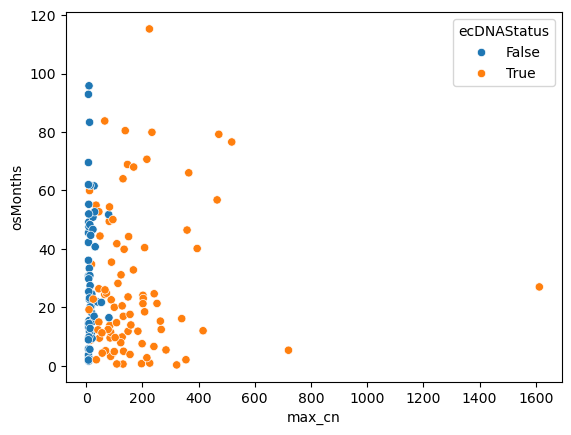

In [ ]:
import seaborn as sn

sns.scatterplot(x = 'max_cn', y = 'osMonths', hue = 'ecDNAStatus', data = ecDNA_patient_cox_specific)

### Gene Level

In [23]:
gene_called_nonecDNA_count = {}
gene_ecDNA_count = {}

for idx, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if row['gene'] in gene_ecDNA_count :
            gene_ecDNA_count[row['gene']] += 1
        else :
            gene_ecDNA_count[row['gene']] = 1
    elif row['ecDNA_status'] == 'non-ecDNA' :
        if row['gene'] in gene_called_nonecDNA_count :
            gene_called_nonecDNA_count[row['gene']] += 1
        else :
            gene_called_nonecDNA_count[row['gene']] = 1




Get IMPACT Lists

In [48]:
im3 = pd.read_excel("./IMPACT341-Gene-List_20140101.xlsx")
im3_genes = set(im3['Gene_Symbol'].unique())

im5 = pd.read_excel("./IMPACT410-Gene-List_20150201.xlsx")
im5_genes = set(im5['Gene_Symbol'].unique())

im6 = pd.read_excel("./impact-genes-468.xlsx")
im6_genes = set(im6['Approved Symbol'].unique())

im7 = pd.read_excel("./IMPACT505_Gene_list_detailed.xlsx", header = None)
im7_genes = set()
for column in im7.columns:
    im7_genes.update(im7[column].unique())
im7_genes.remove(np.nan)

/Users/yuk3/miniconda3/envs/ecDNA/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/yuk3/miniconda3/envs/ecDNA/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [79]:
number_im3 = 0
number_im5 = 0
number_im6 = 0
number_im7 = 0

for sample in echo['sampleId'].unique() :
    try :
        if sample[-3:] == "IM3" :
            number_im3 += 1
        elif sample[-3:] == "IM5" :
            number_im5 += 1
        elif sample[-3:] == "IM6" :
            number_im6 += 1
        elif sample[-3:] == "IM7" :
            number_im7+= 1
    except :
        print(f"Warning: {sample}")

print(f"IM3: {number_im3}")
print(f"IM5: {number_im5}")
print(f"IM6: {number_im6}")
print(f"IM7: {number_im7}")

IM3: 38
IM5: 196
IM6: 1018
IM7: 1100


Plot top genes

In [129]:
gene_ecDNA_percentages = {}

for gene in gene_ecDNA_count :
    new_gene = gene
    if new_gene == "NSD3" :
        new_gene = "WHSC1L1"
    if new_gene == "ELOC" :
        new_gene = "TCEB1"
    if new_gene == "H2BC5" :
        new_gene = "HIST1H2BD"
    if new_gene == "ABRAXAS1" :
        new_gene = "FAM175A"
    if new_gene == "MYCL" :
        new_gene = "MYCL1"
    
    total_num = 0
    if new_gene in im3_genes :
        total_num += number_im3
    if new_gene in im5_genes :
        total_num += number_im5
    if new_gene in im6_genes :
        total_num += number_im6
    if new_gene in im7_genes :
        total_num += number_im7
    if total_num == 0 :
        print(f"{gene} Not Found. Using {number_im3 + number_im5 + number_im6 + number_im7}")
        total_num = number_im3 + number_im5 + number_im6 + number_im7
    gene_ecDNA_percentages[gene] = gene_ecDNA_count[gene]/total_num


EWSR1 Not Found. Using 2352
GTF2I Not Found. Using 2352
PAX8 Not Found. Using 2352
STAT6 Not Found. Using 2352


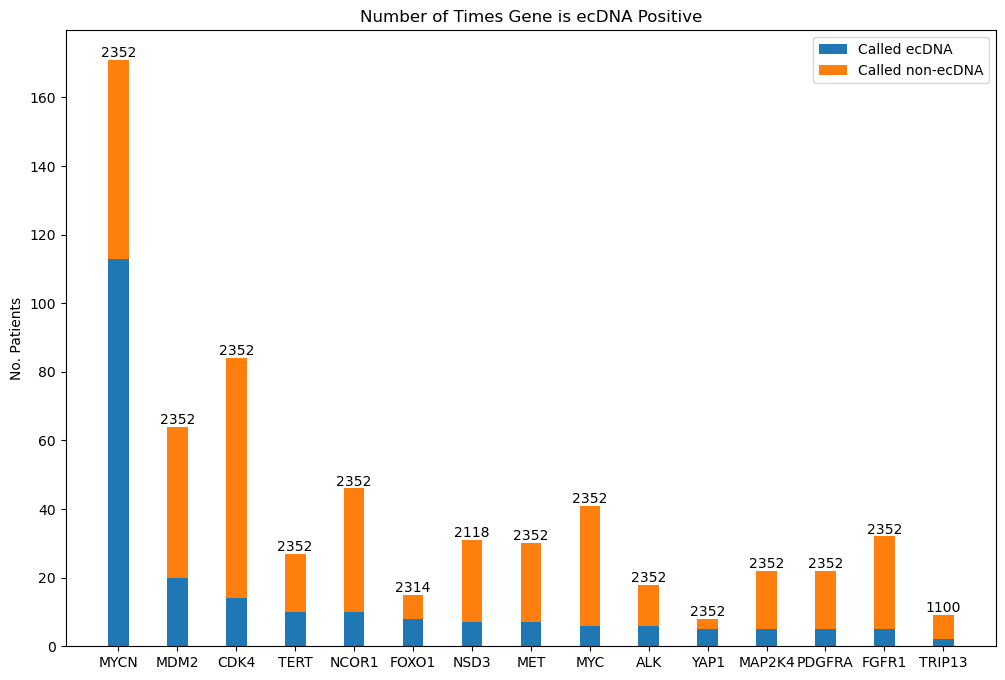

In [133]:
gene_ecDNA_top15 = dict(sorted(gene_ecDNA_percentages.items(), key=lambda x: x[1], reverse=True)[:15])

keys = gene_ecDNA_top15.keys()
ecDNA_neg = [gene_called_nonecDNA_count[key] for key in keys]
ecDNA_pos = [gene_ecDNA_count[key] for key in keys]

ind = np.arange(len(keys))
width = 0.35

plt.figure(figsize = (12, 8))
p1 = plt.bar(ind, ecDNA_pos, width)
p2 = plt.bar(ind, ecDNA_neg, width, bottom=ecDNA_pos)

for i, value in enumerate(gene_ecDNA_top15) :
    if value == "NSD3" :
        value = "WHSC1L1"
    if value == "ELOC" :
        value = "TCEB1"
    if value == "H2BC5" :
        value = "HIST1H2BD"
    if value == "ABRAXAS1" :
        value = "FAM175A"
    if value == "MYCL" :
        value = "MYCL1"

    total_num = 0
    if value in im3_genes :
        total_num += number_im3
    if value in im5_genes :
        total_num += number_im5
    if value in im6_genes :
        total_num += number_im6
    if value in im7_genes :
        total_num += number_im7
    plt.text(i, ecDNA_neg[i] + ecDNA_pos[i], str(total_num), ha = 'center', va = 'bottom')

plt.ylabel('No. Patients')
plt.title('Number of Times Gene is ecDNA Positive')
plt.xticks(ind, keys)
plt.legend((p1[0], p2[0]), ('Called ecDNA', 'Called non-ecDNA'))

plt.show()

Which cancers did these genes come from?

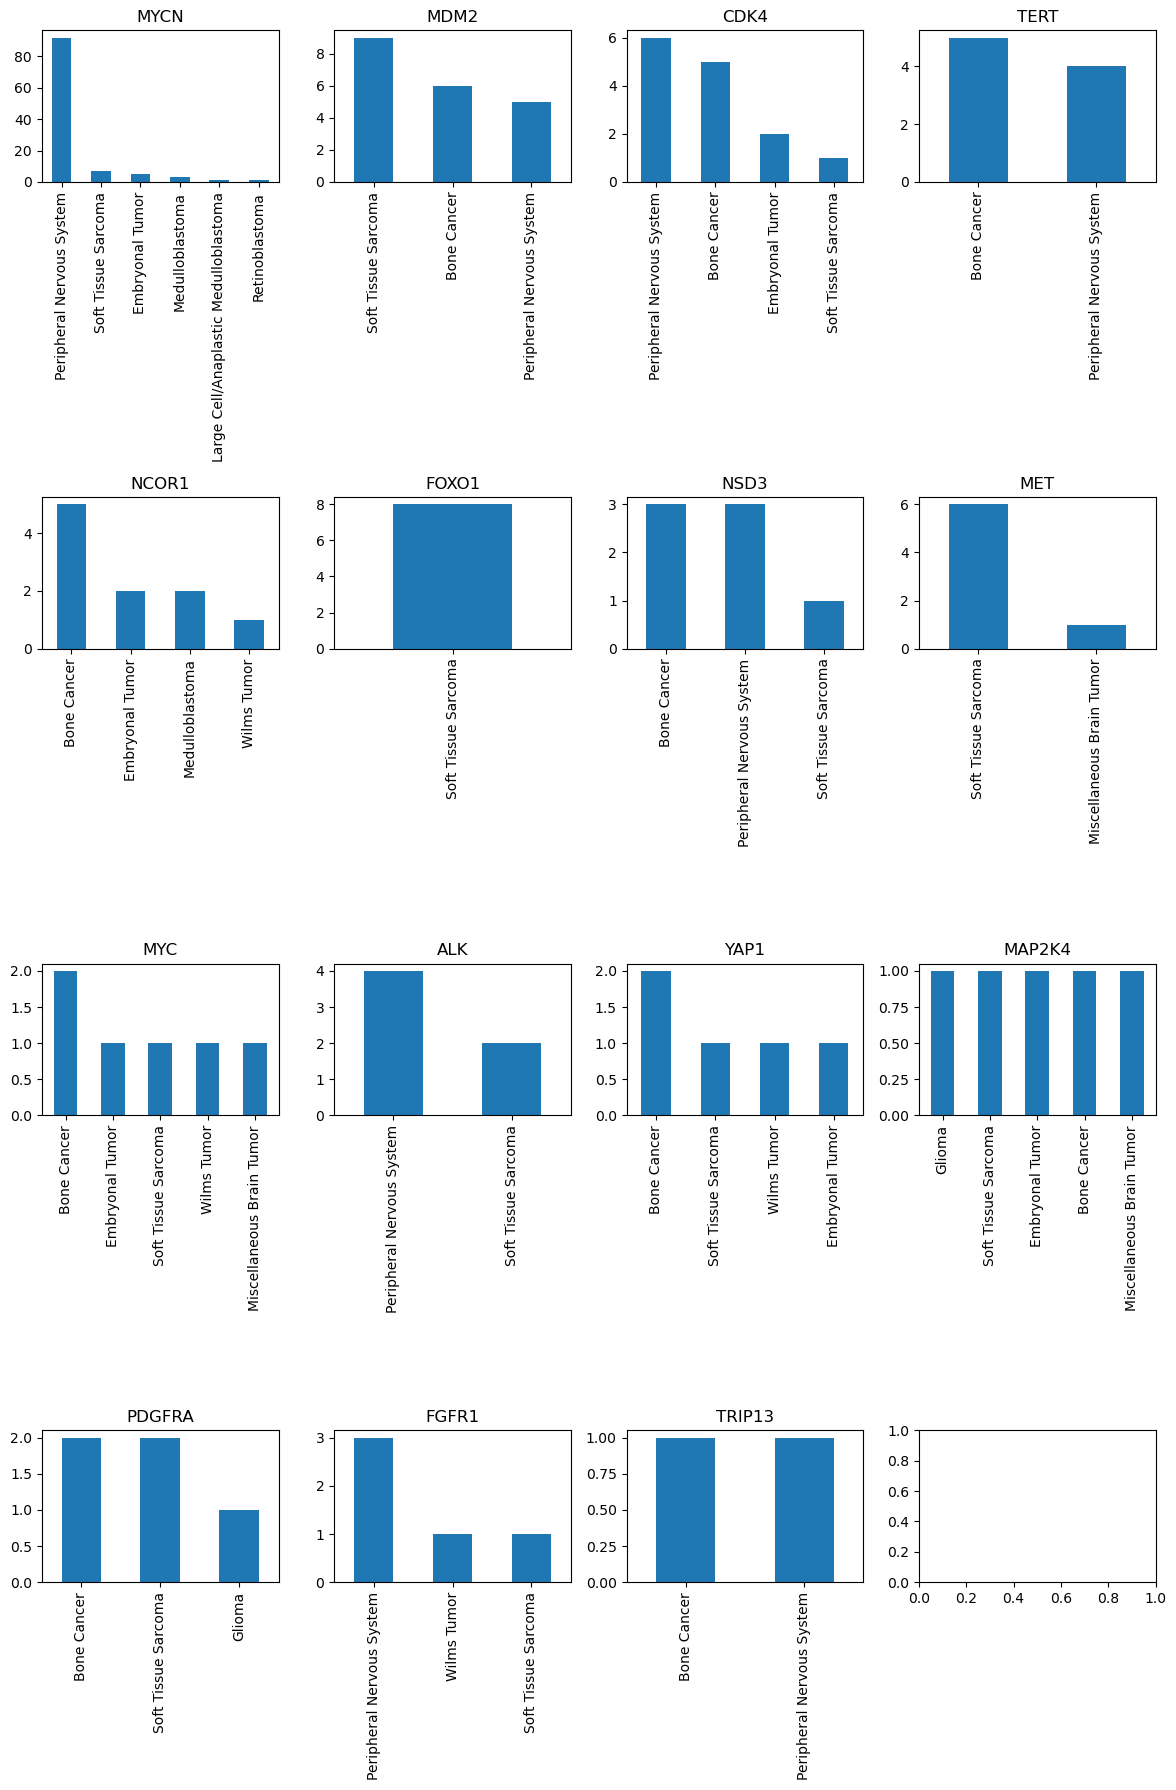

In [134]:
fig, axs = plt.subplots((len(gene_ecDNA_top15)+3)//4, 4, figsize = (12, 1.2 * len(gene_ecDNA_top15)))
axs = axs.flatten()

for i, gene in enumerate(gene_ecDNA_top15) :
        subset = echo[echo['gene'] == gene]
        subset = subset[subset['ecDNA_status'] == 'ecDNA']
        
        counts = subset['cancerType'].value_counts()
        counts.plot(kind = 'bar', ax = axs[i])
        axs[i].set_title(gene)
        axs[i].set_xlabel('')
fig.tight_layout()



Normalized by counts of each cancer (patient wise)

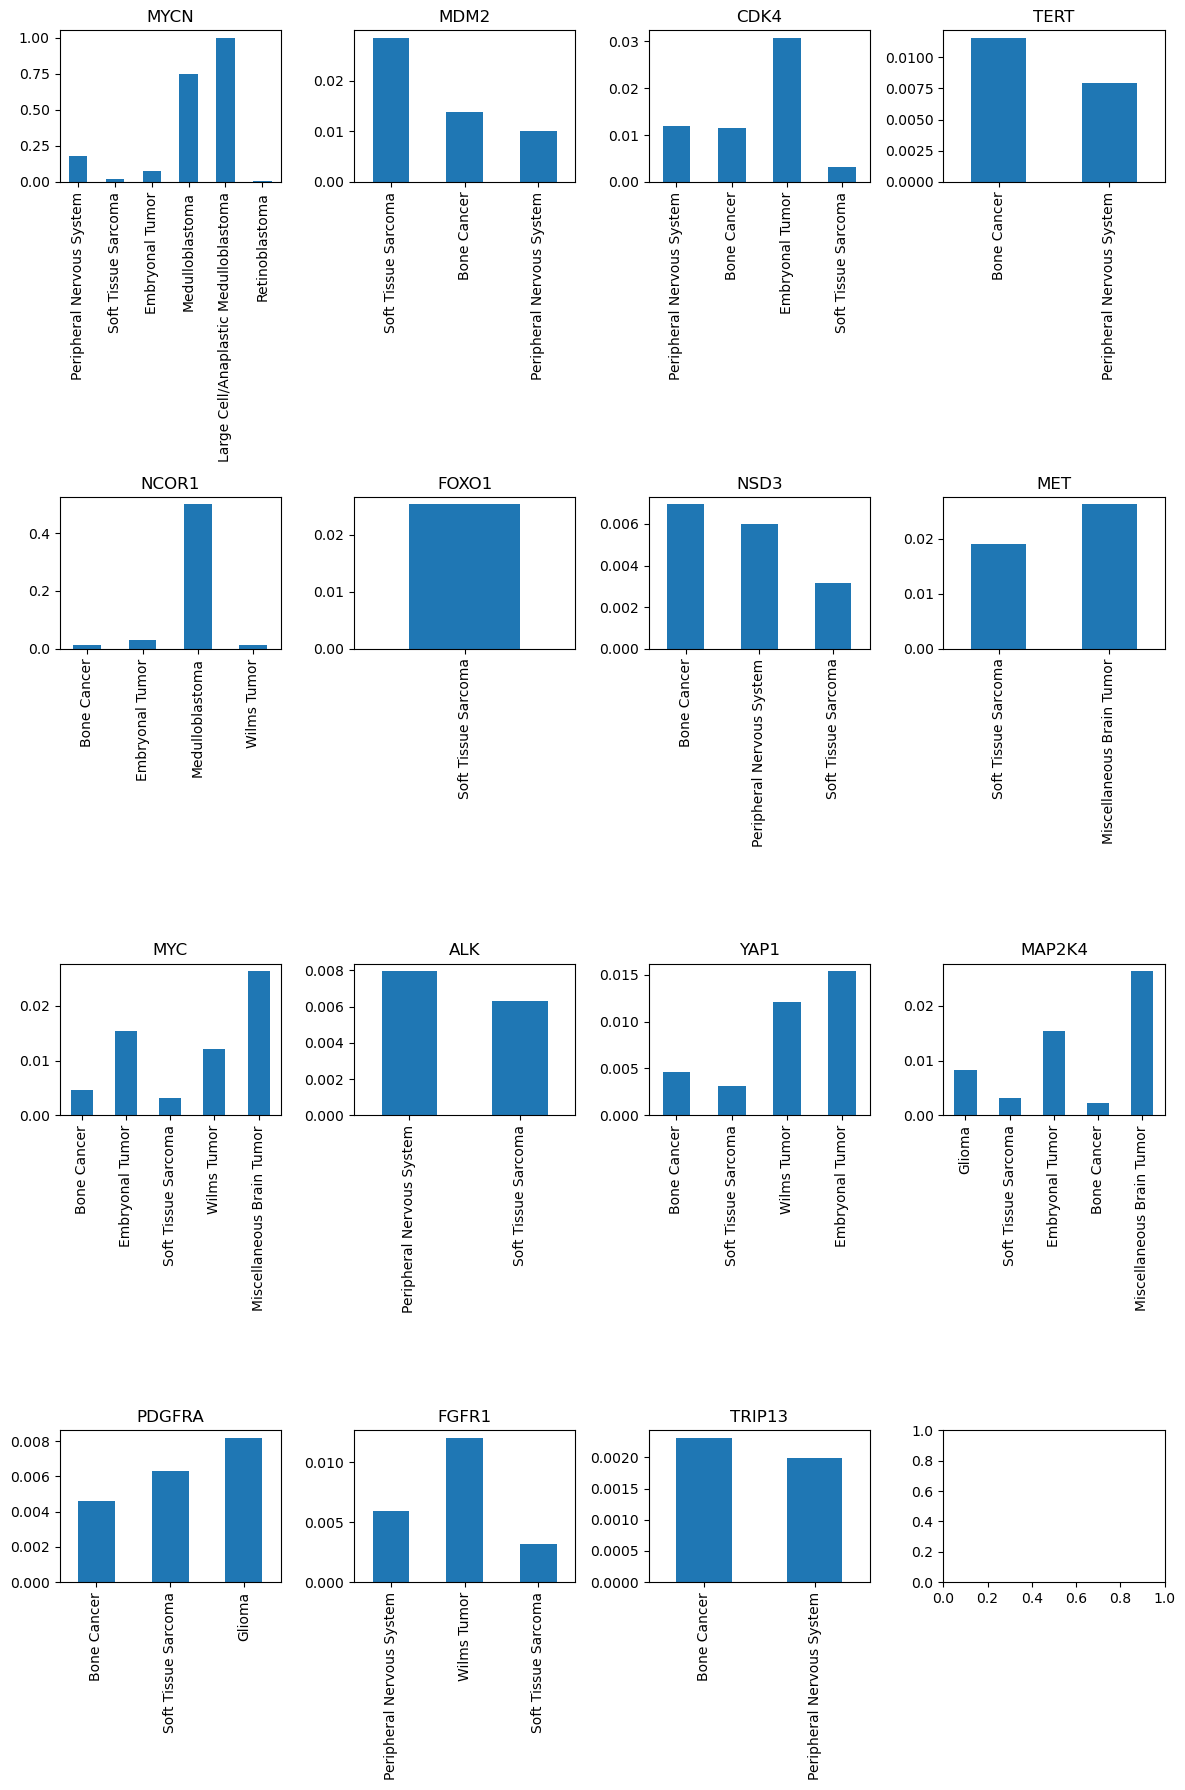

In [135]:
cancerCounts = {}
for i, row in ecDNA_patient.iterrows() :
        if row['cancerType'] in cancerCounts :
                cancerCounts[row['cancerType']] += 1
        else :
                cancerCounts[row['cancerType']] = 1

fig, axs = plt.subplots((len(gene_ecDNA_top15)+3)//4, 4, figsize = (12, 1.2 * len(gene_ecDNA_top15)))
axs = axs.flatten()

for i, gene in enumerate(gene_ecDNA_top15) :
        subset = echo[echo['gene'] == gene]
        subset = subset[subset['ecDNA_status'] == 'ecDNA']
        
        counts = subset['cancerType'].value_counts()
        counts = counts / counts.index.map(cancerCounts)
        counts.plot(kind = 'bar', ax = axs[i])
        axs[i].set_title(gene)
        axs[i].set_xlabel('')
fig.tight_layout()

